# Loading the Data

In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_error
import shap
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, auc
import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


In [5]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [6]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


# Feature Engineering & Data Manipulation

In [7]:
plays = (
    plays
    .assign(
        id = lambda x: x.id.astype(int),
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        seconds_remaining = lambda x: (
            (4 * 15 * 60) - # total game time in seconds
            ((x['period'] - 1) * 15 * 60) - # elapsed quarters in seconds
            (15 * 60 - (x['clock_minutes'] * 60 + x['clock_seconds'])) 
        )
    )
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
    )
)

In [8]:
plays.head()

,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,score_diff,seconds_remaining,pct_game_played,diff_time_ratio
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21,-11,81,0.977500,-548.888472
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31,-11,91,0.974722,-542.823468
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50,-11,50,0.986111,-568.124007
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35,-11,95,0.973611,-540.416272
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0,-7,2940,0.183333,-14.574064


In [9]:
# Find the plays where a timout was called and check if the clock was stopped prior to the play or timeout

plays_key = (
    plays[['game_id','drive_number','play_number','clock_minutes','clock_seconds','period','id',
           'seconds_remaining','play_type','pct_game_played','offense_timeouts','defense_timeouts']]
    .sort_values(
        ['game_id', 'period', 'clock_minutes', 'clock_seconds', 'drive_number', 'play_number'], 
        ascending=[True, True, False, False, True, True]
    )
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={
        'index': 'row_play_id',
        'game_id': 'row_game_id',
    })
    [['id', 'row_play_id','row_game_id','seconds_remaining','play_type','pct_game_played',
      'offense_timeouts','defense_timeouts','drive_number']]
)

# Compute number of earlier plays in the same drive
def count_earlier_plays(df):
    return df['row_play_id'].rank(method='first').astype(int) - 1

tqdm.pandas(desc="Counting number of earlier plays on the same drive")

plays_key['num_prior_plays_on_drive'] = (
    plays_key
    .groupby(['row_game_id', 'drive_number'], group_keys=False)
    .progress_apply(count_earlier_plays)
)

plays_key.drop(columns=['drive_number'], inplace=True)

clock_stopage_play_types = [
    'Pass Incompletion', 
    'Kickoff',
    'Extra Point Good', 
    'Penalty', 
    'Punt', 
    'Pass Interception',
    'Field Goal Good', 
    'Timeout', 
    'Extra Point Missed',
    'Field Goal Missed',
    '2pt Conversion',
    'Safety',
    'End Period', 
    'Passing Touchdown', 
    'Pass Interception Return', 
    'Fumble Recovery (Opponent)',
    'End of Half', 
    'Rushing Touchdown',
    'Interception Return Touchdown', 
    'Kickoff Return Touchdown',
    'Kickoff Return (Offense)', 
    'Blocked Field Goal',
    'Punt Return Touchdown', 
    'Fumble Return Touchdown', 
    'Blocked Punt',
    'Blocked Field Goal Touchdown',
    'Defensive 2pt Conversion', 
    'Blocked Punt Touchdown',
    'Missed Field Goal Return', 
    'Interception',
    'Missed Field Goal Return Touchdown', 
    'Two Point Rush', 
    'Two Point Pass'
]

timeouts = (
    plays
    .query('period.isin([1, 2, 3, 4]) and 0 <= pct_game_played <= 1') # No overtime
    .assign(
        timeout_called = lambda x: x['play_type'] == 'Timeout',
    )
    .merge(
        plays_key[['id', 'row_play_id','num_prior_plays_on_drive']],
        on='id',
        how='left'
    )
    .assign(
        prev_row_play_id = lambda x: x['row_play_id'] - 1,
    )
    .merge(
        plays_key[['row_play_id','row_game_id','seconds_remaining','play_type', 'offense_timeouts', 'defense_timeouts']]
            .rename(columns={
                'row_play_id': 'prev_row_play_id', 
                'row_game_id': 'prev_row_game_id',
                'seconds_remaining': 'prev_seconds_remaining',
                'play_type': 'prev_play_type',
                'offense_timeouts': 'prev_offense_timeouts',
                'defense_timeouts': 'prev_defense_timeouts'
            }
        ),
        on='prev_row_play_id',
        how='left'
    )
    .assign(
        prev_seconds_remaining = lambda x: np.where(
            (x['prev_row_game_id'] != x['game_id']) | # new game start
            ((x['clock_minutes'] == 15) & (x['clock_seconds'] == 0)), # new period start
            x['seconds_remaining'], 
            x['prev_seconds_remaining']
        )
    )
    .assign(
        seconds_elapsed = lambda x: x['prev_seconds_remaining'] - x['seconds_remaining'],
    )
    .query('0<= seconds_elapsed <= 90') # max time elapsed between two play rows ins 40 second runoff + 10 second play + 40 second runoff
    .assign(
        clock_rolling_prior_to_play = lambda x: (
            (x.prev_seconds_remaining != x.seconds_remaining) | # no time change
            (x.prev_play_type.isin(clock_stopage_play_types)) # clock stopage play
        ),
        offense_timeout_called = lambda x: (
            (x['offense_timeouts'] == x['prev_offense_timeouts'] - 1) &
            (x['timeout_called'])
        ),
        defense_timeout_called = lambda x: (
            (x['defense_timeouts'] == x['prev_defense_timeouts'] - 1) &
            (x['timeout_called'])
        ),
        prev_offense_timeouts = lambda x: np.where(
            (x.offense_timeouts == -1) & (x.prev_offense_timeouts == 0),
            1,
            x.prev_offense_timeouts
        ),
        prev_defense_timeouts = lambda x: np.where(
            (x.defense_timeouts == -1) & (x.prev_defense_timeouts == 0),
            1,
            x.prev_defense_timeouts
        )
    )
    .reset_index(drop=True)
)

timeouts.head()

Counting number of earlier plays on the same drive: 100%|██████████| 302826/302826 [00:32<00:00, 9404.66it/s] 


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,score_diff,seconds_remaining,pct_game_played,diff_time_ratio,timeout_called,row_play_id,num_prior_plays_on_drive,prev_row_play_id,prev_row_game_id,prev_seconds_remaining,prev_play_type,prev_offense_timeouts,prev_defense_timeouts,seconds_elapsed,clock_rolling_prior_to_play,offense_timeout_called,defense_timeout_called
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21,-11,81,0.977500,-548.888472,False,152885,2,152884,333610120.0,91.0,Pass Incompletion,0.0,2.0,10.0,True,False,False
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31,-11,91,0.974722,-542.823468,False,152884,1,152883,333610120.0,95.0,Pass Incompletion,0.0,2.0,4.0,True,False,False
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50,-11,50,0.986111,-568.124007,False,152886,3,152885,333610120.0,81.0,Pass Completion,0.0,2.0,31.0,True,False,False
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35,-11,95,0.973611,-540.416272,False,152883,0,152882,333610120.0,104.0,Punt,2.0,0.0,9.0,True,False,False
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0,-7,2940,0.183333,-14.574064,False,152719,5,152718,333610120.0,2965.0,Pass Completion,3.0,3.0,25.0,True,False,False


#### Timeout called about 3% of the time. Drop timeout rows which is not classified as offensive or defensive timemout, then downsample the non-timeout plays to maintain the 3% rate of timeout calls.

In [10]:
timeout_call_rate_before = timeouts.timeout_called.value_counts(normalize=True).iloc[1]
timeout_call_rate_before

0.030094150369832498

In [11]:
timeouts = (
    timeouts
    .query(
        '~timeout_called or '
        '(timeout_called and offense_timeout_called) or '
        '(timeout_called and defense_timeout_called)'
    )
    .reset_index(drop=True)
)

In [12]:
# downsample timeout_called == False plays until the timeout_called == True rate is timeout_call_rate_before
timeout_call_rate_after = timeouts.timeout_called.value_counts(normalize=True).iloc[1].round(3)
print(f'Timeout call rate before: {timeout_call_rate_before}, after: {timeout_call_rate_after}')
if timeout_call_rate_after < timeout_call_rate_before:
    print('Downsampling plays without timeout calls to match the rate of timeout calls')
    timeout_calls = timeouts.query('timeout_called').reset_index(drop=True)
    no_timeout_calls = timeouts.query('~timeout_called').reset_index(drop=True)
    
    no_timeout_calls = no_timeout_calls.sample(
        frac= timeout_call_rate_after / timeout_call_rate_before, 
        random_state=42
    ).reset_index(drop=True)
    
    timeouts = pd.concat([timeout_calls, no_timeout_calls], ignore_index=True).reset_index(drop=True)

Timeout call rate before: 0.030094150369832498, after: 0.028
Downsampling plays without timeout calls to match the rate of timeout calls


In [13]:
timeouts.timeout_called.value_counts(normalize=True)

timeout_called
False    0.969953
True     0.030047
Name: proportion, dtype: float64

### Engineer model features

In [14]:
for c in ['season','week','offense_pregame_elo', 'defense_pregame_elo', 'neutral_site']:
    if c in timeouts.columns:
        timeouts.drop(columns=c, inplace=True)

null_down_and_distance = [
    'Kickoff',
    'Extra Point Good', 
    'Extra Point Missed',
    '2pt Conversion', 
    'Kickoff Return Touchdown',
    'Kickoff Return (Offense)', 
    'Two Point Rush',
    'Two Point Pass'
]

timeouts = (
    timeouts
    .assign(
        yards_to_goal = lambda x: np.where(
            x.play_type.isin(null_down_and_distance),
            np.nan,
            x.yards_to_goal
        ),
        distance = lambda x: np.where(
            x.play_type.isin(null_down_and_distance),
            np.nan,
            x.distance
        ),
        down = lambda x: np.where(
            x.play_type.isin(null_down_and_distance),
            np.nan,
            x.down
        ),
    )
    .query('(0 <= yards_to_goal <= 100) or yards_to_goal.isna()') # yards_to_goal should be between 0 and 100
    .query('(0 <= distance <= 50) or distance.isna()') # distance should be between 0 and 50
    .query('(1 <= down <= 4) or down.isna()') # down should be between 1 and 4
    .merge(
        games[['id', 'season','week','neutral_site']]
            .rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={'team': 'offense', 'elo': 'offense_pregame_elo'}),
        on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={'team': 'defense', 'elo': 'defense_pregame_elo'}),
        on=['season', 'week', 'defense'],
        how='left'
    )
    .assign(
        offense_is_home = lambda x: np.where(
            x.neutral_site,
            0,
            np.where(x['offense'] == x['home'], 1, -1)
        ),
        defense_is_home = lambda x: np.where(
            x.neutral_site,
            0,
            np.where(x['defense'] == x['home'], 1, -1)
        ),
        is_redzone = lambda x: np.where(
            x['yards_to_goal'] <= 20,
            1,
            0
        ),
        is_goal_to_go = lambda x: np.where(
            x['yards_to_goal'] <= x['distance'],
            1,
            0
        ),
    )
)

In [15]:
# Drop plays where offense has no timeouts left -> probability of timeout call is 0
timeouts = (
    timeouts
    .query('prev_offense_timeouts != 0')
    .reset_index(drop=True)
)

# Offenseive Timeout Model

In [16]:
feature_names = [
    'prev_offense_timeouts', 
    'yards_to_goal',
    'down',
    'distance',
    'pct_game_played',
    'score_diff',
    'diff_time_ratio',
    'clock_rolling_prior_to_play',
    'offense_pregame_elo',
    'defense_pregame_elo',
    'offense_is_home',
    'num_prior_plays_on_drive',
    'is_redzone',
    'is_goal_to_go',
]

data = timeouts[feature_names + ['offense_timeout_called']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['offense_timeout_called']
)
test_x, test_y = test_data[feature_names], test_data['offense_timeout_called']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data['offense_timeout_called'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['offense_timeout_called']
)

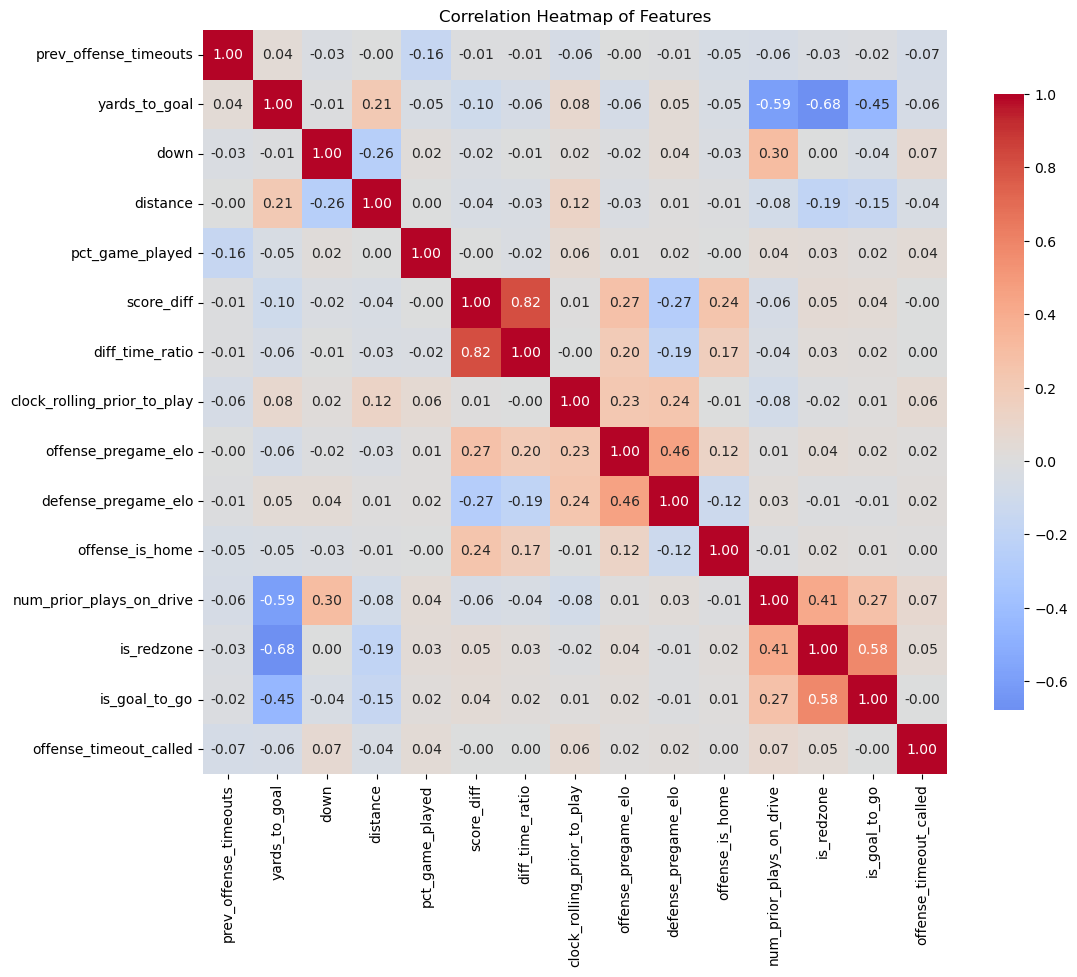

In [17]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [18]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="offensive_timeout_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(
    lambda trial: objective(trial, dtrain, dvalid), 
    n_trials=50,
    show_progress_bar=True
)
# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    # 'interaction_constraints': interaction_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")
precision, recall, _ = precision_recall_curve(train_y, train_preds)
pr_auc = auc(recall, precision)
print(f"Final train PR AUC: {pr_auc:0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")
precision, recall, _ = precision_recall_curve(valid_y, valid_preds)
pr_auc = auc(recall, precision)
print(f"Final validation PR AUC: {pr_auc:0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(test_x, label= test_y)
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(test_y, test_preds):0.3f}")
precision, recall, _ = precision_recall_curve(test_y, test_preds)
pr_auc = auc(recall, precision)
print(f"Final test PR AUC: {pr_auc:0.3f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Number of boosted rounds: 237
Final train log loss: 0.051
Final train PR AUC: 0.370
Final validation log loss: 0.056
Final validation PR AUC: 0.279
Final test log loss: 0.056
Final test PR AUC: 0.271


In [19]:
p = timeouts.offense_timeout_called.value_counts(normalize=True).values[1]
baseline_log_loss = -(p * np.log(p) + (1 - p) * np.log(1 - p))
print(f"Baseline probability of offenseive timeout call: {p:0.3f}")
print(f"Baseline log loss: {baseline_log_loss:0.3f}")

Baseline probability of offenseive timeout call: 0.016
Baseline log loss: 0.081


100%|██████████| 10/10 [02:09<00:00, 12.95s/it]
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66697/506683757.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


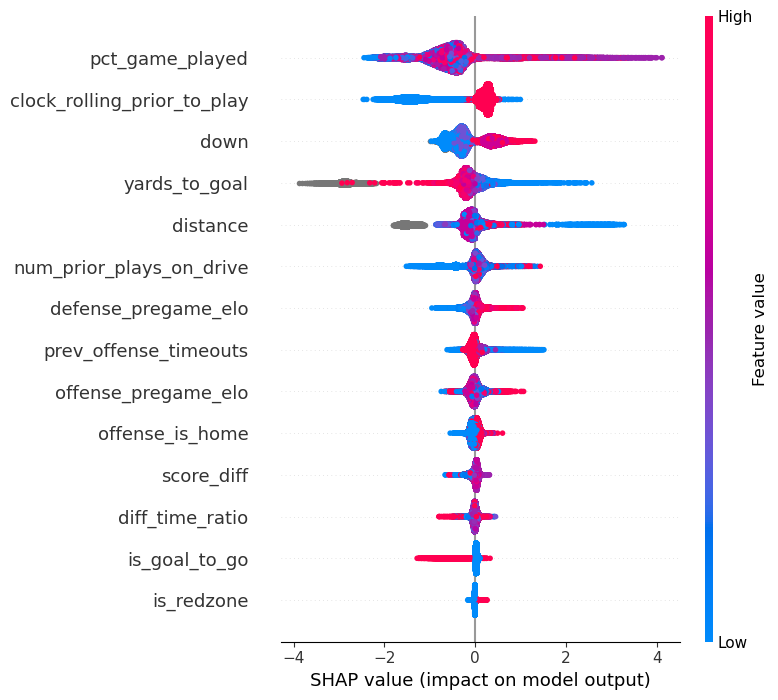

In [43]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(final_model)

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

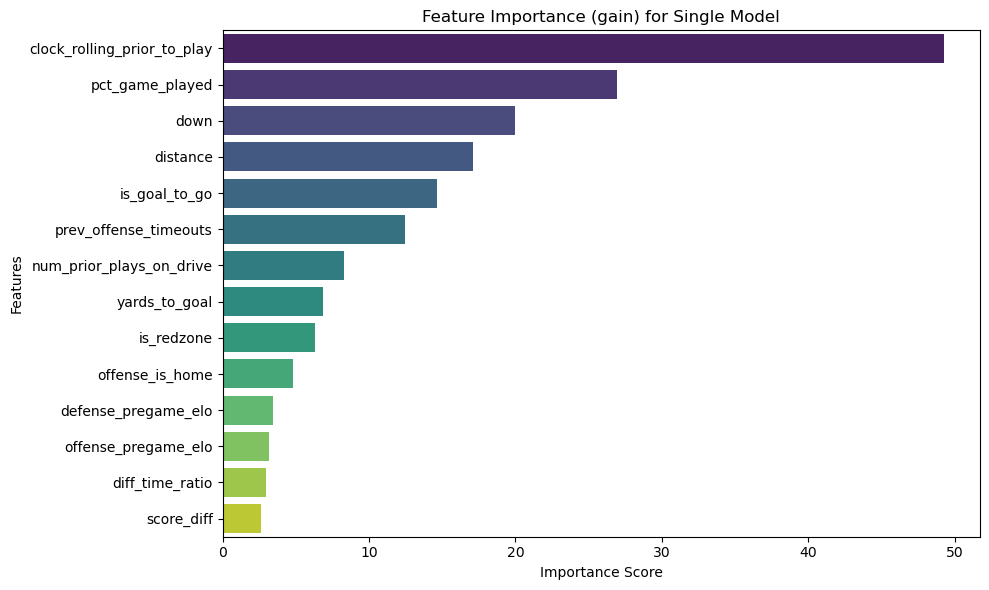

In [21]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [22]:
# predict offensive_timeout_call for all plays
timeouts['offensive_timeout_proba'] = final_model.predict(xgb.DMatrix(timeouts[feature_names]))

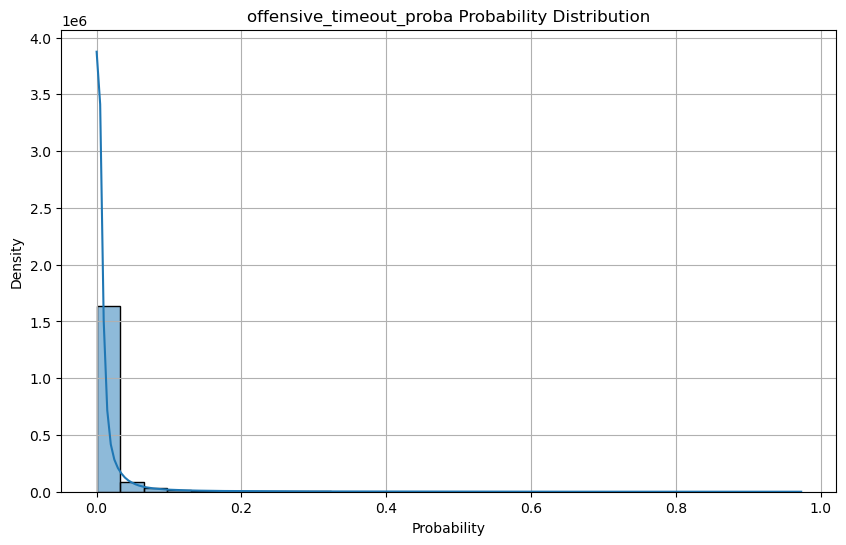

In [23]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(timeouts, col='offensive_timeout_proba')

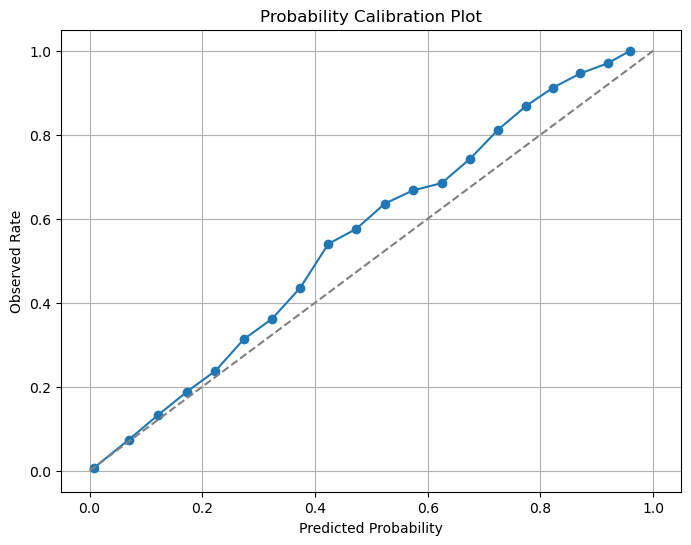

In [24]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(timeouts, proba_col='offensive_timeout_proba', actual_col='offense_timeout_called', bins=20)

In [28]:
timeouts[feature_names + ['offense_timeout_called', 'offensive_timeout_proba']].sort_values(
    by='offensive_timeout_proba', 
    ascending=False,
    ignore_index=True
).head(30)

,prev_offense_timeouts,yards_to_goal,down,distance,pct_game_played,score_diff,diff_time_ratio,clock_rolling_prior_to_play,offense_pregame_elo,defense_pregame_elo,offense_is_home,num_prior_plays_on_drive,is_redzone,is_goal_to_go,offense_timeout_called,offensive_timeout_proba
0,3.0,4.0,1.0,10.0,0.490000,7,49.695289,False,2147.472465,1734.266591,1,6,1,1,True,0.973248
1,3.0,41.0,2.0,16.0,0.486111,-17,-118.825709,False,2771.959768,3019.069440,0,8,0,0,True,0.966633
2,3.0,7.0,1.0,10.0,0.493611,-6,-43.215703,False,2252.331364,2268.078769,1,8,1,1,True,0.965470
3,3.0,4.0,1.0,10.0,0.487778,14,98.511022,False,1818.191962,1839.768336,1,7,1,1,True,0.965220
4,2.0,53.0,2.0,11.0,0.495278,-17,-123.263514,False,2842.140258,3415.747730,0,8,0,0,True,0.960396
5,2.0,2.0,2.0,0.0,0.495833,6,43.601554,False,2834.196431,3655.819886,0,10,1,0,True,0.956088
6,3.0,5.0,1.0,10.0,0.494722,10,72.347000,False,3563.680223,1750.671454,-1,2,1,1,True,0.952460
7,3.0,8.0,2.0,0.0,0.490278,7,49.750537,False,2982.486308,2285.024063,1,12,1,0,True,0.952254
8,2.0,16.0,4.0,3.0,0.991389,-5,-263.747833,False,3023.418859,2717.081283,0,10,1,0,True,0.950668
9,3.0,6.0,1.0,10.0,0.484722,10,69.510233,False,2861.361891,1390.430864,1,13,1,1,True,0.950654


In [ ]:
model_dir = join('../models/raw', 'timeout')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"offense_timeout_classifier_xgb.bin")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../models/raw/timeouts' folder.


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66697/1788131053.py:6: UserWarning: [13:48:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  final_model.save_model(model_path)


# Defensive Timeout Model

In [46]:
feature_names = [
    'prev_defense_timeouts', 
    'yards_to_goal',
    'down',
    'distance',
    'pct_game_played',
    'score_diff',
    'diff_time_ratio',
    'clock_rolling_prior_to_play',
    'offense_pregame_elo',
    'defense_pregame_elo',
    'defense_is_home',
    'num_prior_plays_on_drive',
    'is_redzone',
    'is_goal_to_go',
]

data = timeouts[feature_names + ['defense_timeout_called']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['defense_timeout_called']
)
test_x, test_y = test_data[feature_names], test_data['defense_timeout_called']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data['defense_timeout_called'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['defense_timeout_called']
)

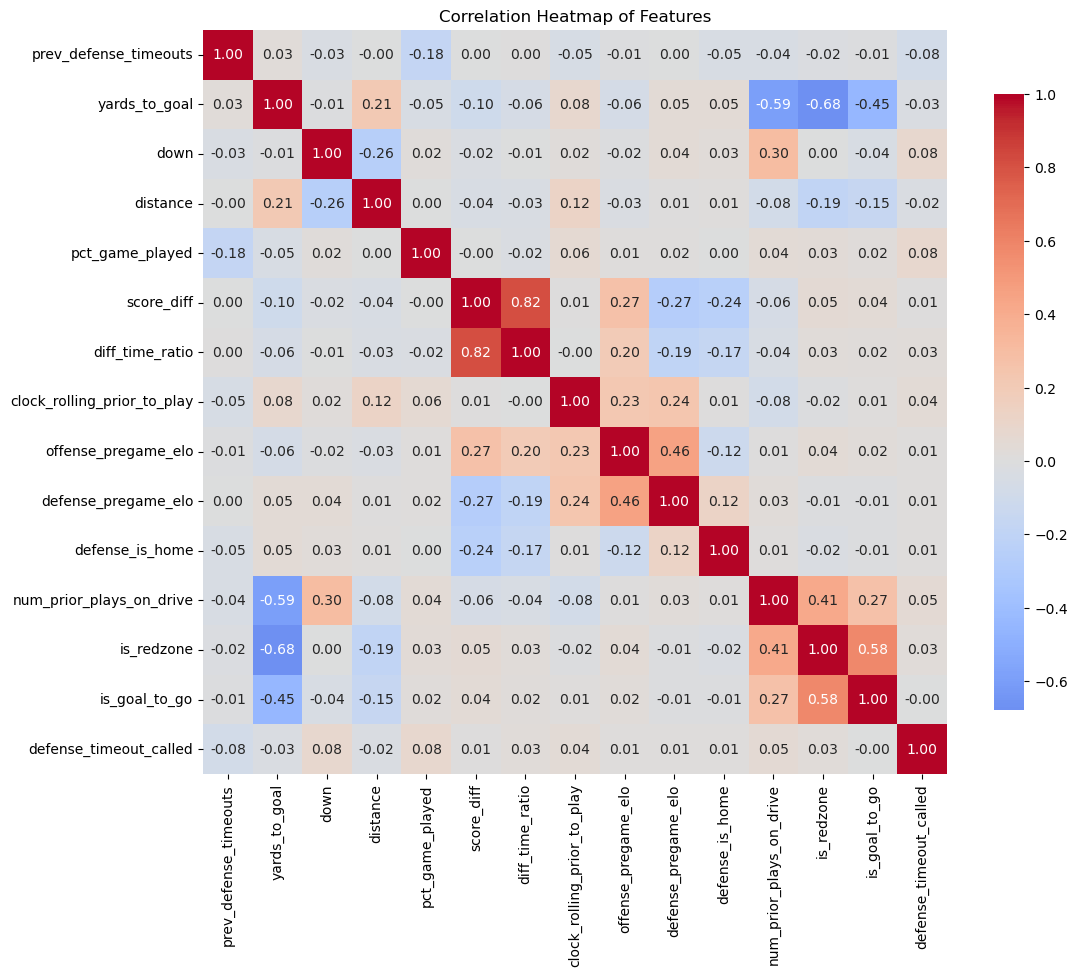

In [47]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [48]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="defensive_timeout_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(
    lambda trial: objective(trial, dtrain, dvalid), 
    n_trials=50,
    show_progress_bar=True
)
# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    # 'interaction_constraints': interaction_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")
precision, recall, _ = precision_recall_curve(train_y, train_preds)
pr_auc = auc(recall, precision)
print(f"Final train PR AUC: {pr_auc:0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")
precision, recall, _ = precision_recall_curve(valid_y, valid_preds)
pr_auc = auc(recall, precision)
print(f"Final validation PR AUC: {pr_auc:0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(test_x, label= test_y)
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(test_y, test_preds):0.3f}")
precision, recall, _ = precision_recall_curve(test_y, test_preds)
pr_auc = auc(recall, precision)
print(f"Final test PR AUC: {pr_auc:0.3f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Number of boosted rounds: 480
Final train log loss: 0.041
Final train PR AUC: 0.455
Final validation log loss: 0.045
Final validation PR AUC: 0.369
Final test log loss: 0.045
Final test PR AUC: 0.359


In [49]:
p = timeouts.defense_timeout_called.value_counts(normalize=True).values[1]
baseline_log_loss = -(p * np.log(p) + (1 - p) * np.log(1 - p))
print(f"Baseline probability of defensive timeout call: {p:0.3f}")
print(f"Baseline log loss: {baseline_log_loss:0.3f}")

Baseline probability of defensive timeout call: 0.014
Baseline log loss: 0.073


100%|██████████| 10/10 [02:12<00:00, 13.28s/it]
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66697/506683757.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


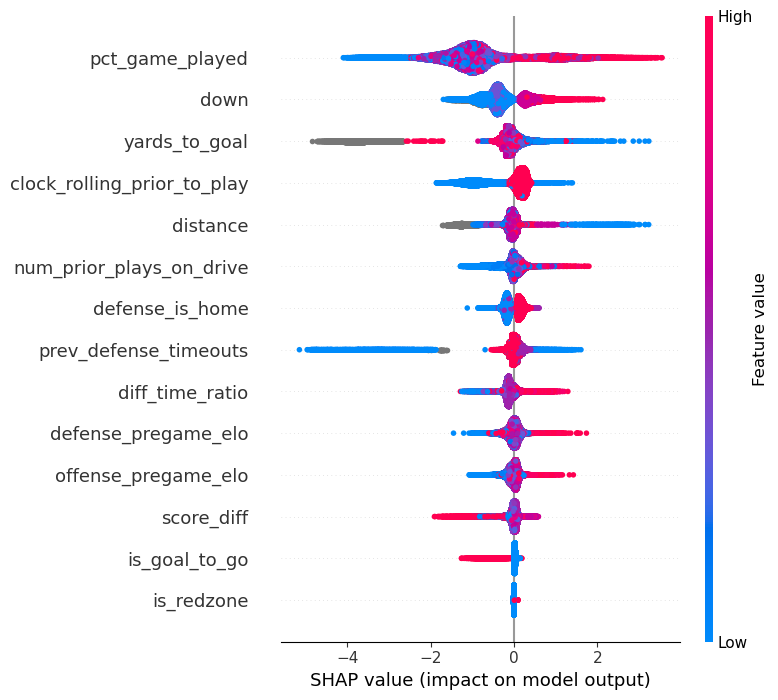

In [50]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(final_model)

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

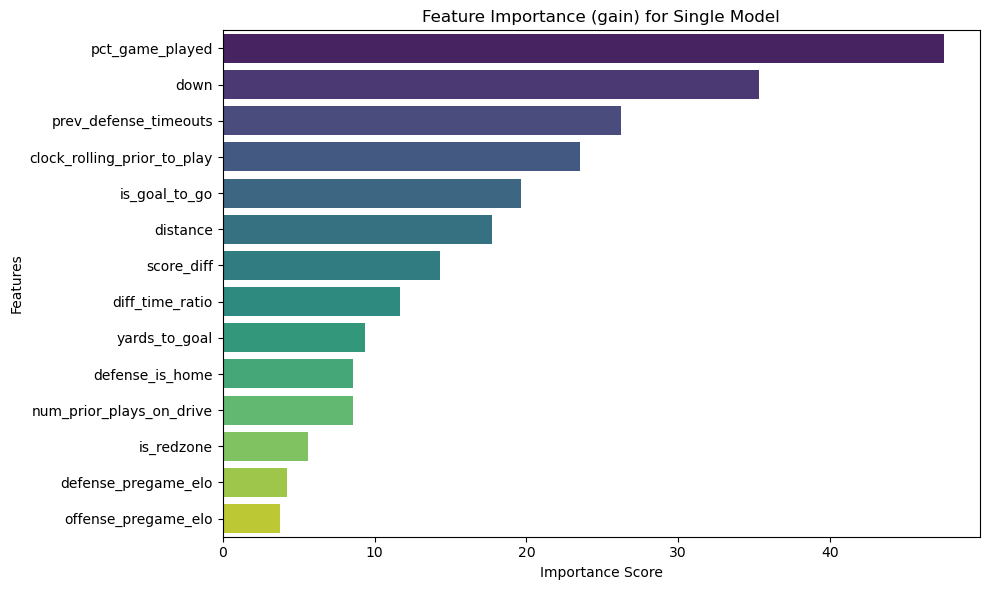

In [56]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [57]:
# predict offensive_timeout_call for all plays
timeouts['defensive_timeout_proba'] = final_model.predict(xgb.DMatrix(timeouts[feature_names]))

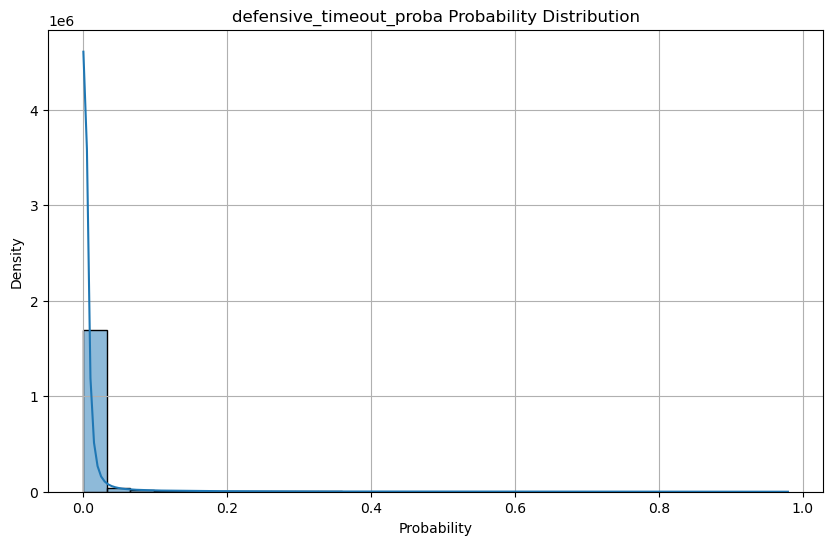

In [58]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(timeouts, col='defensive_timeout_proba')

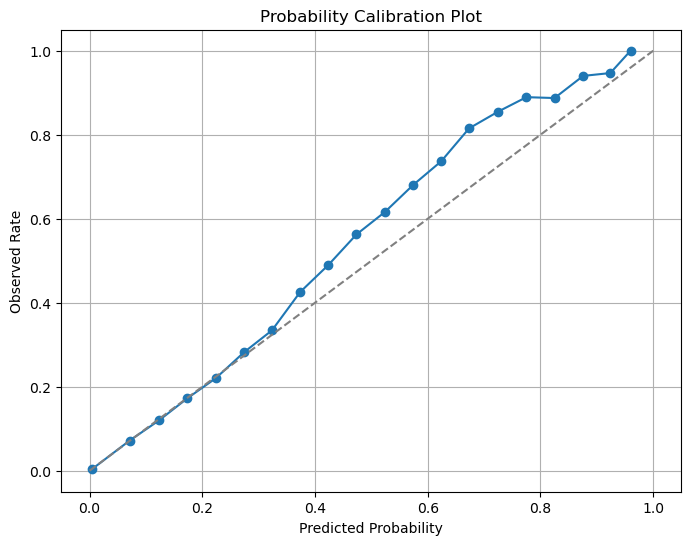

In [59]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(timeouts, proba_col='defensive_timeout_proba', actual_col='defense_timeout_called', bins=20)

In [60]:
timeouts[feature_names + ['defense_timeout_called', 'defensive_timeout_proba']].sort_values(
    by='defensive_timeout_proba',
    ascending=False,
    ignore_index=True
).head(30)

,prev_defense_timeouts,yards_to_goal,down,distance,pct_game_played,score_diff,diff_time_ratio,clock_rolling_prior_to_play,offense_pregame_elo,defense_pregame_elo,defense_is_home,num_prior_plays_on_drive,is_redzone,is_goal_to_go,defense_timeout_called,defensive_timeout_proba
0,2.0,50.0,3.0,9.0,0.971111,7,340.479389,False,3047.263849,3501.210170,0,4,0,0,True,0.979145
1,1.0,50.0,4.0,8.0,0.978333,7,350.458915,False,2890.725018,3060.747710,-1,9,0,0,True,0.976979
2,1.0,61.0,4.0,20.0,0.972500,7,342.376206,False,3047.263849,3501.210170,0,6,0,0,True,0.976753
3,-1.0,3.0,1.0,10.0,0.322778,7,25.457777,True,1671.361055,1539.776207,1,0,1,1,True,0.973048
4,2.0,55.0,3.0,13.0,0.976111,7,347.357529,False,2890.725018,3060.747710,-1,7,0,0,True,0.972106
5,2.0,75.0,3.0,5.0,0.978611,7,350.848531,False,2623.459952,3088.409015,-1,3,0,0,True,0.970269
6,3.0,77.0,2.0,7.0,0.976389,7,347.743697,False,2623.459952,3088.409015,-1,1,0,0,True,0.968764
7,2.0,17.0,3.0,0.0,0.973333,6,294.445169,False,2325.883565,2768.555695,-1,6,1,0,True,0.966933
8,1.0,62.0,4.0,6.0,0.972222,7,341.995999,False,2986.004510,2779.228650,-1,5,0,0,True,0.966765
9,2.0,47.0,4.0,6.0,0.955278,10,456.549078,False,3030.655765,2828.281602,1,7,0,0,True,0.966484


In [ ]:
model_dir = join('../models/raw', 'timeout')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"defense_timeout_classifier_xgb.bin")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../models/raw/timeouts' folder.


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_66697/4274786530.py:6: UserWarning: [14:04:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  final_model.save_model(model_path)
